[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed. 



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

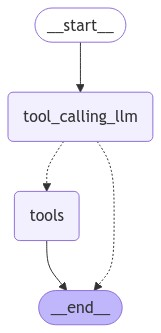

In [7]:
# Section 1: Get OpenAPI KEY

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

# ------------------ 
# Section 2: Define your tool, and also bind in GPT-4o model
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

# ------------------ 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode #  Allows the tool to be used
from langgraph.prebuilt import tools_condition # object controls 

# Recall the definition of MessagesState - allows for tracking and cumulative collection of msgs
# This will do adding and annotation. This code below tells LangGraph to append messages
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

# Node Function applied at Node #1
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]} 
    # This function is 

# Build graph
builder = StateGraph(MessagesState)

# Node 1 - Regular Node that checks condition, "Tool Calling"
builder.add_node("tool_calling_llm", tool_calling_llm)

# Node 2 - The tool itself
builder.add_node("tools", ToolNode([multiply])) # This will actually call and be able to use the Multiply tool
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", # name of the node
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, # controls routing
)

# Connect node of tools to END
builder.add_edge("tools", END)

# Compile the LangGraph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

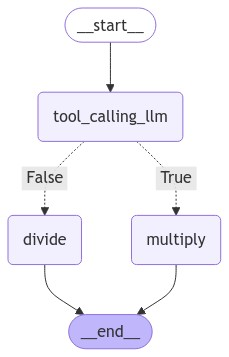

In [18]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

# Define multiple tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b.
    Args:
        a: first int
        b: second int
    """
    return (a / b)

# Bind tools to the LLM
llm_with_tools = llm.bind_tools([multiply, divide])

# Node function to decide the flow
def tool_calling_llm(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

# Build the graph
builder = StateGraph(MessagesState)

# Node 1: LLM Call
builder.add_node("tool_calling_llm", tool_calling_llm)

# Node A: Tool multiply
builder.add_node("multiply", ToolNode([multiply]))

# Node B: Tool divide
builder.add_node("divide", ToolNode([divide]))

# Define the flow
builder.add_edge(START, "tool_calling_llm")  # Start with LLM call
builder.add_conditional_edges(
    "tool_calling_llm",  # Depending on the LLM output, route to multiply or divide
    tools_condition,  # Condition based on the LLM response
    path_map = {True: "multiply",
            False: "divide"}
)

# Connect each tool node to the end
builder.add_edge("multiply", END)
builder.add_edge("divide", END)

# Compile the graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hi ChatGPT, how's it hanging?", name= "Christine")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Christine

Hi ChatGPT, how's it hanging?
================================== Ai Message ==================================

Hey Christine! I'm just a bunch of code, so no hanging for me, but I'm here and ready to help you with anything you need. How are you doing today?


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.